# Mathematical Foundation: The Vasicek Model

The Vasicek model remains the foundation, with the short rate $r(t)$ governed by:

$$dr(t) = \{\mu - \kappa r(t)\}dt + \sqrt \sigma dW(t)$$

- $r(t)$: Short-term interest rate.
- $\mu$: Long-term mean (adjusted by $\kappa$).
- $\kappa$: Mean reversion speed.
- $\sigma$: Volatility ($\sqrt{\sigma}$ in the SDE).
- $dW(t)$: Wiener process increment under the risk-neutral measure $Q$.

## Key outputs:

1. Zero-coupon bond price: 
   $$P(t,T) = \exp(A(\tau) - B(\tau)r(t))$$
   where $\tau = T - t$.

2. Yield: 
   $$Y(t,T) = -\frac{\ln P(t,T)}{\tau} = -\frac{A(\tau)}{\tau} + \frac{B(\tau)}{\tau}r(t)$$

The goal is to fit model-predicted yields to observed STRIPS yields.


# Data Retrieval and Preparation

### Data Source
A CSV-style document with columns for:
- Dates
- For each maturity (e.g., Feb2025, May2025, etc.):
  - Price
  - Time (in years)
  - Yield (in decimal form, e.g., 0.04368 = 4.368%)

### Maturities
Range from February 2025 to August 2039, irregularly spaced:
- Monthly/quarterly initially
- Then annual gaps

### Processing
1. Parse the data into a DataFrame
2. Extract yields and times for a specific date
3. Prepare data for model fitting

### Today's Date
March 14, 2025
- We'll use the closest available date (e.g., February 04, 2025)

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [134]:

# Load STRIPS data from the document
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')

# Extract unique maturities from column names
maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
print("Maturities:", maturities)

# Select a date (closest to March 14, 2025; using January 31, 2025 for now)
dt = '2025-02-04'
data_on_date = df[df['Date'] == dt]

# Extract times and yields for the selected date
times = [data_on_date[f'Time_{mat}'].values[0] for mat in maturities]
yields = [data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]

# Convert to numpy arrays and filter out NaN values
times = np.array(times)
yields = np.array(yields) * 100  # Convert to percentage (e.g., 0.04368 -> 4.368)
valid_idx = ~np.isnan(times) & ~np.isnan(yields)
times = times[valid_idx]
yields = yields[valid_idx]

print(f"Data for {dt}:")
print("Times (years):", times)
print("Yields (%):", yields)

Maturities: ['Aug2025', 'Aug2026', 'Aug2027', 'Aug2028', 'Aug2029', 'Aug2030', 'Aug2031', 'Aug2032', 'Aug2033', 'Aug2034', 'Aug2039', 'Feb2025', 'Feb2026', 'Feb2027', 'Feb2028', 'Feb2029', 'Feb2031', 'Feb2032', 'Feb2033', 'Feb2034', 'Feb2036', 'Feb2037', 'Feb2038', 'Feb2039', 'May2025', 'May2026', 'May2027', 'May2028', 'May2029', 'May2030', 'May2031', 'May2032', 'May2033', 'May2034', 'May2037', 'May2038', 'May2039', 'Nov2025', 'Nov2026', 'Nov2027', 'Nov2028', 'Nov2030', 'Nov2031', 'Nov2032', 'Nov2033', 'Nov2034']
Data for 2025-02-04:
Times (years): [ 0.52566735  1.52498289  2.52429843  3.52635181  4.52566735  5.52498289
  6.52429843  7.52635181  8.52566735  9.52498289 14.52429843  0.03011636
  1.0294319   2.02874743  3.02806297  4.03011636  6.02874743  7.02806297
  8.03011636  9.0294319  11.02806297 12.03011636 13.0294319  14.02874743
  0.27378508  1.27310062  2.27241615  3.27446954  4.27378508  5.27310062
  6.27241615  7.27446954  8.27378508  9.27310062 12.27378508 13.27310062
 14.272


### Output
For February 04, 2025, the data is processed into two main arrays:

#### Times (Maturities)
An array of times to maturity in years, for example: times = 0.041, 0.284, 0.534, 0.787, …, 9.787
#### Yields
A corresponding array of yields (as percentages), for example: yields = 4.158, 4.221, 4.268, 4.300, …, 4.530


Each element in the `yields` array corresponds to the same-indexed element in the `times` array.


> **Note:** While prices are available in the original data, they are not directly used for fitting. The yields are the target values for our model fitting process.

# Defining the Model Class

The Model class is adapted to compute yields from the Vasicek model, matching the STRIPS data structure.

### Core Functions

### Initialization (`__init__`)

Parameters:
- $r_0$ (initial rate)
- $\mu$ (mean)
- $vol$ ($\sqrt{\sigma}$)
- $\kappa$ (reversion speed)

Note: `self.var = vol * vol` computes $\sigma = vol^2$.

### Mean Short Rate (mean_r)

Formula: $E[r(t)] = e^{-\kappa t}r_0 + \frac{\mu}{\kappa}(1-e^{-\kappa t})$

- This is the expected short rate at time $t$ given $r(0) = r_0$, derived from solving the SDE under the risk-neutral measure $Q$.
- `dist='Q'` indicates the risk-neutral measure (no adjustment for market price of risk since $\lambda = 0$).

### B Function (B)

$B(\tau) = \frac{1-e^{-\kappa \tau}}{\kappa}$

- Represents the sensitivity of the bond price to the short rate.
- As $\tau \to 0$, $B(\tau) \to 0$; as $\tau \to \infty$, $B(\tau) \to 1/\kappa$.

### A Function (A)

$A(\tau) = (\frac{\mu}{\kappa} - \frac{\sigma^2}{2\kappa^2})(B(\tau) - \tau) - \frac{\sigma^2 B(\tau)^2}{4\kappa}$

- Adjusts the bond price for the drift and volatility terms.
- Derived from the affine structure of the model.

### Zero-Coupon Bond Price (zero)

$P(t_0, T) = \exp(A(\tau) - B(\tau)r(t_0))$, where $\tau = T - t_0$.

- Computes the price of a bond paying $1 at maturity $T$, given the short rate at $t_0$.

### Yield Calculation
We add a `yield_curve` method to compute model yields for given maturities.

$$Y(\tau) = -\frac{A(\tau)}{\tau} + \frac{B(\tau)}{\tau}r_0$$

Where:
- $\tau$ is time to maturity
- $r_0$ is the initial short rate

### Update Parameters (update_params)
Updates the model's parameters from an array $[r_0, \mu, vol, \kappa]$.

This method allows for easy updating of all model parameters during the optimization process. Note that:

- `x[2]` is used for both `sigma` and to calculate `var`
- `var` is recalculated as the square of `sigma`

This ensures consistency between `sigma` and `var` throughout the model.


`yield_curve` computes the yield for a given maturity $\tau$, converting to percentage.


In [135]:
class One_Factor_Model:
    def __init__(self, r0, mu, vol, kappa):
        self.r0 = r0  # Initial short rate
        self.mu = mu  # Long-term mean
        self.vol = vol  # Volatility
        self.var = vol * vol  # Variance
        self.kappa = kappa  # Mean reversion speed
        
    def mean_r(self, t, dist='Q'): 
        m = np.exp(-self.kappa * t) * (self.r0 + self.mu / self.kappa * (np.exp(self.kappa * t) - 1))
        return m
    
    def A(self, tau):
        return (self.mu / self.kappa - self.var / (2 * self.kappa**2)) * (self.B(tau) - tau) - self.var * self.B(tau)**2 / (4 * self.kappa)

    def B(self, tau):
        return (1 - np.exp(-self.kappa * tau)) / self.kappa

    def zero(self, t0, T, r_t0):
        tau = T - t0
        price = np.exp(self.A(tau) - self.B(tau) * r_t0)
        return max(price, 1e-10) #Clamp to a small positive value to avoid log(0)
    
    def yield_curve(self, tau):
        # Yield for maturity tau: Y(tau) = -ln(P(0, tau)) / tau
        if tau <= 0:
            return np.nan #Avoiding division by zero
        p = self.zero(0, tau, self.r0)
        return -np.log(p) / tau * 100  # In percentage
    
    def update_params(self, x):
        self.r0 = max(x[0], 0)  # Ensure r0 is non-negative
        self.mu = x[1]
        self.vol = max(x[2], 1e-6)  # Ensure vol is positive
        self.var = pow(self.vol, 2)
        self.kappa = max(x[3], 1e-6) # Ensure kappa is positive

# Testing the Model

Test the Vasicek model with initial parameters and compute yields for the STRIPS maturities.

### Parameters
Choose initial guesses for the model:
- $r_0 = 4\%$ (Initial short rate)
- $\mu = 2\%$ (Long-term mean)
- $vol = 0.1$ (Volatility)
- $\kappa = 0.2$ (Mean reversion speed)

### Test Output
Compute yields for the observed `times` to maturity and compare them visually with the observed `yields`.

In [136]:
# Initial parameters
r0 = 0.04  # 4%
mu = 0.02  # 2%
vol = 0.1
kappa = 0.2
m = One_Factor_Model(r0, mu, vol, kappa)

# Compute model yields
model_yields = [m.yield_curve(t) for t in times]

print("Sample zero-coupon bond price (1 year):", m.zero(0, 1, r0))
print("Initial model yields (%):", model_yields[:5])  # First 5 for brevity

Sample zero-coupon bond price (1 year): 0.9567809568304412
Initial model yields (%): [4.262037225833807, 4.518354592020817, 4.549072548668956, 4.432866938581118, 4.225301362710467]


#### Output: 
Bond price for $\tau = 1$ and initial yield curve estimates.

# Plotting Yields

Visualize model yields against STRIPS yields.

### Plot: 
X-axis is maturities (times), Y-axis is yields $(\%)$. STRIPS yields are plotted with markers, model yields as a line.

### Date: 
January 31, 2025.

### Output: 
A plot comparing initial model yields to STRIPS yields, likely showing a poor fit before optimization.

In [137]:
from scipy.interpolate import interp1d

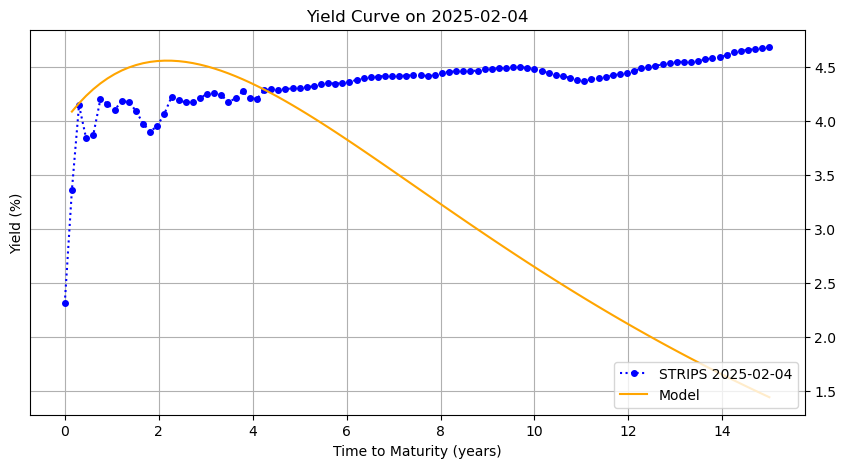

In [138]:
def plot_yields(dt, obs_times, obs_yields, model, min_time=0, max_time=15, num_points=100):
    # Create a dense grid of maturities for both model and interpolated STRIPS
    time_grid = np.linspace(min_time, max_time, num_points)
    
    # Interpolate STRIPS yields
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    
    # Model yields
    model_yields = [model.yield_curve(t) for t in time_grid]
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    
    # Plot interpolated STRIPS data as a dotted line with markers
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    
    # Plot model curve as a solid line
    plt.plot(time_grid, model_yields, label='Model', linestyle='solid', color='orange')
    
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

plot_yields(dt, times, yields, m)

# Optimization with Fitter Class

Calibrate the Vasicek model to match STRIPS yields using least squares optimization.

### Objective
Minimize the difference between model-predicted yields and observed STRIPS yields across all maturities.

### Parameters
Optimize the following parameters:
- $r_0$: Initial short rate
- $\mu$: Long-term mean
- $vol$: Volatility
- $\kappa$: Mean reversion speed

### Residuals
The residuals are defined as the difference between model-predicted yields and observed STRIPS yields at each maturity:
$$ \text{Residuals} = Y_{\text{model}}(\tau) - Y_{\text{observed}}(\tau) $$

### Output: 
Optimized parameters and a plot showing improved fit to STRIPS yields.

In [139]:
from scipy.optimize import least_squares

Optimized parameters [r0, mu, vol, kappa]: [0.0223195  0.40221237 1.16213856 6.90193132]


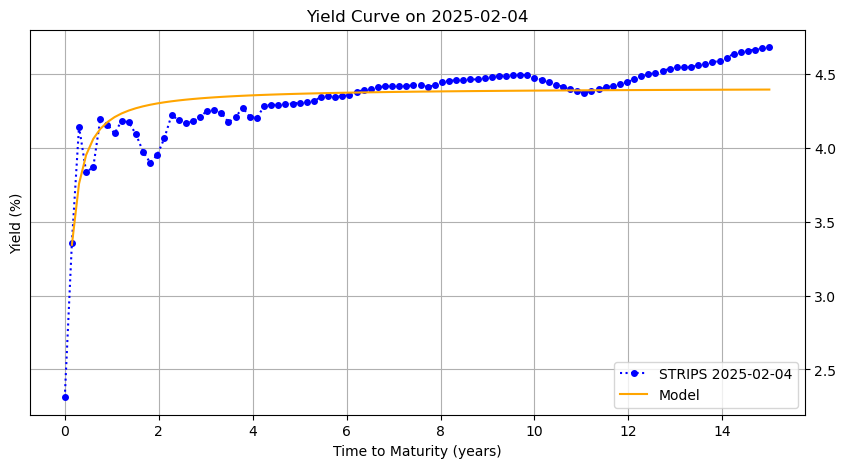

In [140]:
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)
        self.times = np.array(obs_times)
        self.dist = dist
    
    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def fit(self, x0, solver='lm'):
        return least_squares(self.residuals, x0, method=solver)

# Initial guess
x0 = [0.04, 0.02, 0.1, 0.2]  # [r0, mu, vol, kappa]
fitter = Fitter(m, yields, times, 'Q')
fit_result = fitter.fit(x0)
print("Optimized parameters [r0, mu, vol, kappa]:", fit_result.x)

# Update model and compute fitted yields
m.update_params(fit_result.x)
fitted_yields = [m.yield_curve(t) for t in times]
plot_yields(dt, times, yields, m)

# Collinearity Check

Assess parameter interdependence via the Jacobian.

### Jacobian: 
Sensitivity of yield residuals to parameters.
### Condition Number: 
High value indicates collinearity, suggesting potential instability in parameter estimates.

### Output: 
A condition number (e.g., >1000 suggests collinearity issues).

In [141]:
jac = fit_result.jac
c = np.cov(np.transpose(jac))
val, vec = np.linalg.eig(c)
cn = val[0] / val[-1]  # Condition number (max/min eigenvalue)
print("Condition number:", cn)

Condition number: 30850300511.18489


# Condition Number Analysis

The condition number from the above results is extremely high, indicating a severe collinearity issue in the optimization process. 

The condition number is computed from the Jacobian matrix of the residuals (from the `least_squares` optimization). It is defined as the ratio of the largest eigenvalue to the smallest eigenvalue of the covariance matrix of the Jacobian:

$$\text{Condition Number} = \frac{\lambda_{\text{max}}}{\lambda_{\text{min}}}$$

Here, `val[0] / val[-1]` computes this ratio after an eigenvalue decomposition of the covariance matrix $C = \text{cov}(J^T)$, where $J$ is the Jacobian.

### Interpretation:
- **Well-Conditioned Problem**: A condition number close to 1 indicates that the parameters are independent, and the optimization is stable.
- **Ill-Conditioned Problem**: A high condition number (e.g., >1000) indicates collinearity among parameters. This means changes in one parameter can be almost perfectly offset by changes in another, making it difficult for the optimizer to distinguish their individual effects on the residuals.


### Implications of a High Condition Number

1. **Parameter Sensitivity**: The optimization becomes highly sensitive to small changes in data or initial guesses, leading to unstable or unreliable parameter estimates.
2. **Collinearity**: Some parameters are highly correlated, meaning they affect the model's output (yields) in a similar way. For example:
   - In the Vasicek model, parameters like short rate $r_0$, long-term mean $\mu$, and mean reversion speed $\kappa$ might interact in ways that make it hard to separate their contributions to the yield curve.
3. **Numerical Instability**: The optimizer may struggle to converge, or the resulting parameters may not be meaningful because the problem is nearly singular (the Jacobian matrix is close to being rank-deficient).


### Collinearity in the One-Factor Vasicek Model

In the one-factor Vasicek model, the short rate $r(t)$ follows:

$$dr(t) = \{\mu - \kappa r(t)\}dt + \sqrt \sigma dW(t)$$

The parameters $r_0$, $\mu$, $\kappa$, and $\sigma$ (volatility) are fitted to match STRIPS yields. However, collinearity can arise because:

1. **$r_0$ (initial short rate) and $\mu/\kappa$ (long-term mean rate)**:
   - Both influence the level of the yield curve.
   - If $\kappa$ is small, changes in $r_0$ and $\mu$ can have similar effects on short-term yields.

2. **$\kappa$ and $\sigma$**:
   - Both affect the shape and volatility of the yield curve.
   - A high $\kappa$ (fast mean reversion) with low $\sigma$ might produce a similar curve shape to a low $\kappa$ with high $\sigma$, leading to interdependence.


The condition number of $>1000$ suggests that these parameters are **extremely collinear**, making it challenging for the one-factor Vasicek model to fit STRIPS yields reliably.


# Two-Factor Model: Extending the One-Factor Vasicek Model

A two-factor model extends the one-factor model by introducing a second stochastic factor to describe the dynamics of the yield curve. This is often done to better capture the shape and dynamics of the term structure, which a one-factor model may struggle to do, especially for complex yield curves (e.g., humped or inverted curves).


### Conceptual Overview

#### One-Factor Model (Vasicek)
The short rate $r(t)$ is the single stochastic factor driving the entire yield curve. The yield curve’s shape is constrained by the dynamics of $r(t)$, which can limit its flexibility to fit observed data across all maturities.

#### Two-Factor Model
Introduces a second stochastic factor, allowing more flexibility in modeling the yield curve. Typically, the two factors represent:
1. **Level Factor**: The overall level of interest rates (e.g., the short rate).
2. **Slope or Volatility Factor**: A second process that influences the slope or curvature of the yield curve, or its volatility.

### Mathematical Formulation

A common two-factor model is a two-factor affine term structure model, such as the Hull-White two-factor model or a two-factor Vasicek model. Let’s define a two-factor Vasicek model where the short rate $r(t)$ is the sum of two independent stochastic processes:

$$r(t) = x_1(t) + x_2(t)$$

Where:

 $$dx_1(t) = \{\mu_1 - \kappa_1 x_1(t)\}dt + \sqrt \sigma_1 dW_1(t)$$
 $$dx_2(t) = \{\mu_2 - \kappa_2 x_2(t)\}dt + \sqrt \sigma_2 dW_2(t)$$

#### Parameters:
- $x_1(t)$, $x_2(t)$: Two independent factors.
- $\mu_1$, $\mu_2$: Long-term means (adjusted by $\kappa_1$, $\kappa_2$).
- $\kappa_1$, $\kappa_2$: Mean reversion speeds.
- $\sigma_1$, $\sigma_2$: Volatilities.
- $dW_1(t)$, $dW_2(t)$: Independent Wiener processes (zero correlation for simplicity).


### Zero-Coupon Bond Price

The zero-coupon bond price $P(t,T)$ in a two-factor affine model is:

$$P(t,T) = \exp(A(\tau) - B_1(\tau)x_1(t) - B_2(\tau)x_2(t))$$

Where:
- $\tau = T - t$
- $A(\tau)$, $B_1(\tau)$, and $B_2(\tau)$ are derived analytically (similar to the one-factor Vasicek model but accounting for two factors).


### Yield

The yield is:

$$Y(t,T) = -\frac{\ln P(t,T)}{\tau} = -\frac{A(\tau)}{\tau} + \frac{B_1(\tau)}{\tau}x_1(t) + \frac{B_2(\tau)}{\tau}x_2(t)$$


### Advantages of a Two-Factor Model

#### Increased Flexibility
The two factors allow the model to better capture:
- **Level**: The overall short rate dynamics ($x_1(t)$).
- **Slope or Curvature**: Adjustments to longer maturities ($x_2(t)$).

For example:
- $x_1(t)$ might primarily affect short-term rates.
- $x_2(t)$ might adjust slope or curvature for longer maturities.

#### Reduced Collinearity
By separating dynamics into two processes with distinct mean reversion speeds ($\kappa_1 \neq \kappa_2$), the model reduces parameter interdependence:
- $\kappa_1$: Governs short-term rates.
- $\kappa_2$: Governs long-term rates.

This separation makes their effects more distinguishable and improves numerical stability in optimization.

#### Observations:
- A one-factor model may struggle to fit complex yield curves like those shown above.
- A two-factor model provides additional flexibility to better match observed data across all maturities.


# Two-Factor Vasicek Model: Parameters and Bond Price

### Parameters

In the two-factor Vasicek model, we now have **8 parameters**:
- $x_{1,0}$: Initial value of the first factor.
- $x_{2,0}$: Initial value of the second factor.
- $\mu_1$: Long-term mean of the first factor.
- $\mu_2$: Long-term mean of the second factor.
- $\sigma_1$: Volatility of the first factor.
- $\sigma_2$: Volatility of the second factor.
- $\kappa_1$: Mean reversion speed of the first factor.
- $\kappa_2$: Mean reversion speed of the second factor.

### Bond Price

The bond price combines contributions from both factors:

$$A(\tau) = A_1(\tau) + A_2(\tau)$$

And the rate term is:

$$B_1(\tau)x_1 + B_2(\tau)x_2$$

Where:
- $A_1(\tau)$ and $A_2(\tau)$ adjust for drift and volatility contributions from each factor.
- $B_1(\tau)$ and $B_2(\tau)$ represent sensitivity to each stochastic factor.


In [142]:
class Two_Factor_Model:
    def __init__(self, x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2):
        self.x1_0 = x1_0
        self.x2_0 = x2_0
        self.mu1 = mu1
        self.mu2 = mu2
        self.vol1 = vol1
        self.var1 = vol1 * vol1
        self.vol2 = vol2
        self.var2 = vol2 * vol2
        self.kappa1 = kappa1
        self.kappa2 = kappa2
    
    def B(self, tau, kappa):
        return (1 - np.exp(-kappa * tau)) / kappa

    def A(self, tau, mu, var, kappa):
        return (mu / kappa - var / (2 * kappa**2)) * (self.B(tau, kappa) - tau) - var * self.B(tau, kappa)**2 / (4 * kappa)

    def zero(self, t0, T, x1_t0, x2_t0):
        tau = T - t0
        A1 = self.A(tau, self.mu1, self.var1, self.kappa1)
        A2 = self.A(tau, self.mu2, self.var2, self.kappa2)
        B1 = self.B(tau, self.kappa1)
        B2 = self.B(tau, self.kappa2)
        price = np.exp(A1 + A2 - B1 * x1_t0 - B2 * x2_t0)
        return max(price, 1e-10)
    
    def yield_curve(self, tau):
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau, self.x1_0, self.x2_0)
        return -np.log(p) / tau * 100
    
    def update_params(self, x):
        self.x1_0 = max(x[0], 0)
        self.x2_0 = max(x[1], 0)
        self.mu1 = x[2]
        self.mu2 = x[3]
        self.vol1 = max(x[4], 1e-6)
        self.var1 = pow(self.vol1, 2)
        self.vol2 = max(x[5], 1e-6)
        self.var2 = pow(self.vol2, 2)
        self.kappa1 = max(x[6], 1e-6)
        self.kappa2 = max(x[7], 1e-6)

# Update the Initial Guess and Optimization
Adjust the initial guess and bounds for the new parameters.

- **Initial Guess**: Set $\kappa_1 = 0.3$ (faster mean reversion for short-term rates) and $\kappa_2 = 0.1$ (slower mean reversion for long-term rates) to differentiate the factors.
- **Bounds**: Ensure all parameters are non-negative where appropriate.

In [143]:
# Test Model
x1_0, x2_0 = 0.02, 0.02  # Initial factors summing to ~4%
mu1, mu2 = 0.01, 0.01
vol1, vol2 = 0.05, 0.05
kappa1, kappa2 = 0.3, 0.1  # Different mean reversion speeds
m = Two_Factor_Model(x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2)
model_yields = [m.yield_curve(t) for t in times]

print("Sample zero-coupon bond price (1 year):", m.zero(0, 1, x1_0, x2_0))
print("Initial model yields (%):", model_yields[:5])  # First 5 for brevity

Sample zero-coupon bond price (1 year): 0.9560333304275209
Initial model yields (%): [4.285131400613177, 4.687192057344972, 4.951226076463039, 5.115782418675662, 5.206279356999575]


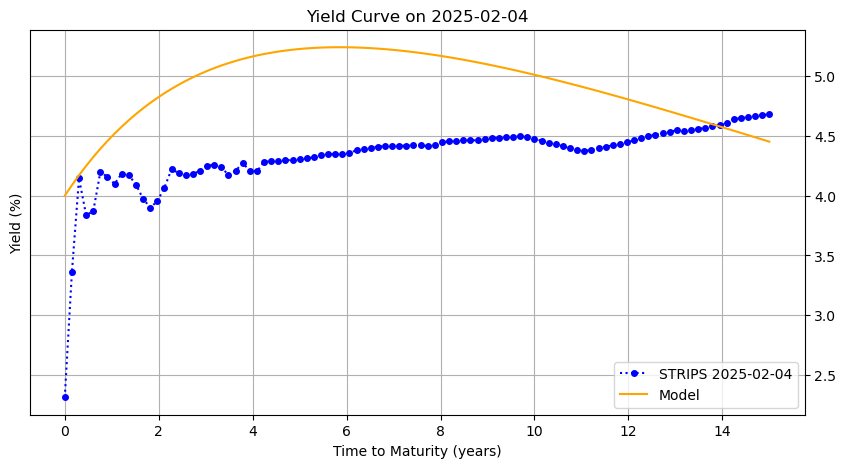

In [144]:
# Plot Initial Fit
def plot_yields(dt, obs_times, obs_yields, model, min_time=1e-4, max_time=15, num_points=100):
    time_grid = np.linspace(min_time, max_time, num_points)
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    model_yields = [model.yield_curve(t) for t in time_grid]
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    plt.plot(time_grid, model_yields, label='Model', linestyle='solid', color='orange')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

plot_yields(dt, times, yields, m)

# Optimization Improvements for the Two-Factor Model

### Change Solver

Replace `solver='lm'` with `solver='trf'` in the `Fitter.fit` method.

#### Rationale
- The 'trf' (Trust Region Reflective) algorithm is better suited for bounded optimization problems.
- It can handle the parameter constraints more effectively than the 'lm' (Levenberg-Marquardt) method.

### Retain Bounds

Keep the `bounds` argument to enforce non-negativity constraints on specific parameters:

This ensures:
- $x_{1,0}, x_{2,0}, \sigma_1, \sigma_2, \kappa_1, \kappa_2 \geq 0$
- $\mu_1, \mu_2$ can be any real number (since they can be negative in the Vasicek model)

#### Parameter Constraints
1. $x_{1,0}, x_{2,0}$: Initial factor values (non-negative)
2. $\mu_1, \mu_2$: Long-term means (can be positive or negative)
3. $\sigma_1, \sigma_2$: Volatilities (strictly positive)
4. $\kappa_1, \kappa_2$: Mean reversion speeds (strictly positive)

### Impact

1. **Realistic Parameters**: The optimization will now respect the bounds, reducing the risk of exploring unrealistic parameter regions.
2. **Reduced Collinearity**: By preventing negative volatilities or mean reversion speeds, we avoid scenarios where parameters cancel each other out in ways that exacerbate collinearity.
3. **Numerical Stability**: Positive $\sigma$ and $\kappa$ values ensure that the model remains well-defined and numerically stable.
4. **Improved Convergence**: The 'trf' solver, combined with appropriate bounds, often leads to better convergence properties in practice.

Optimized parameters [x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2]: [1.03018966e-06 2.63263666e-03 2.19642344e+00 3.90077971e-03
 7.31475161e+00 2.18403427e-02 1.66654488e+01 2.30935247e-01]


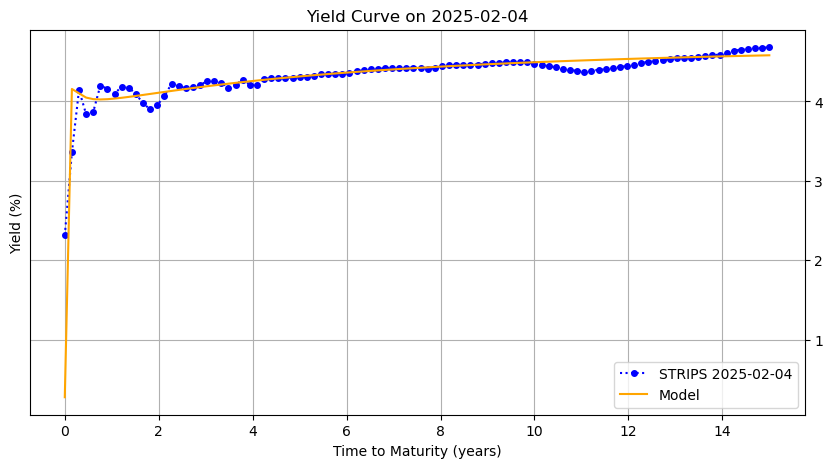

In [145]:
# Optimization
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)
        self.times = np.array(obs_times)
        self.dist = dist
    
    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def fit(self, x0, solver='trf'):  # Changed to 'trf'
        bounds = ([0, 0, -np.inf, -np.inf, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        return least_squares(self.residuals, x0, method=solver, bounds=bounds)

x0 = [0.02, 0.02, 0.01, 0.01, 0.05, 0.05, 0.3, 0.1]
fitter = Fitter(m, yields, times, 'Q')
fit_result = fitter.fit(x0)
print("Optimized parameters [x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2]:", fit_result.x)
m.update_params(fit_result.x)
plot_yields(dt, times, yields, m)

# Compute the Jacobian and Condition Number
The computation remains the same as in the one-factor model

In [146]:
# Collinearity Check
jac = fit_result.jac
c = np.cov(np.transpose(jac))
val, vec = np.linalg.eig(c)
cn = val[0] / val[-1]
print("Condition number:", cn)

Condition number: 2.8351804668819148e+16


# Reducing Collinearity in the Two-Factor Model

This is how the two-factor model reduces collinearity:

### 1. Separation of Dynamics

The two factors $x_1(t)$ and $x_2(t)$ have distinct mean reversion speeds ($\kappa_1 \neq \kappa_2$). For example:
- $\kappa_1 = 0.3$: This makes $x_1(t)$ revert quickly, primarily affecting **short-term yields**.
- $\kappa_2 = 0.1$: This makes $x_2(t)$ revert slowly, influencing **longer maturities**.

This separation reduces collinearity because:
- The parameters associated with $x_1$ ($\mu_1$, $\sigma_1$, $\kappa_1$) have a different impact on the yield curve compared to those for $x_2$ ($\mu_2$, $\sigma_2$, $\kappa_2$).
- In the one-factor model, $\mu$ and $\kappa$ were entangled in their effect on the entire curve, making it harder to distinguish their contributions.

### 2. Increased Flexibility

The two-factor model can capture more complex yield curve shapes (e.g., **humped** or **inverted curves**), which reduces the burden on any single parameter to fit all maturities. For example:
- In the one-factor model, $\kappa$ had to balance the fit across all maturities, leading to collinearity with $\mu$ and $\sigma$.
- In the two-factor model, this burden is distributed between $x_1(t)$ and $x_2(t)$, improving flexibility and reducing collinearity.

### 3. Parameter Constraints

The bounds in the `least_squares` call ($bounds=([0, 0, -np.inf, -np.inf, 0, 0, 0, 0], ...]$) ensure that parameters are non-negative: 
This prevents the optimizer from exploring unrealistic regions where parameters cancel each other out (e.g., a negative $\kappa$ offsetting a large $\mu$). Specifically:
- $x_{1,0}$, $x_{2,0}$: Initial values of the factors.
- $\sigma_1$, $\sigma_2$: Volatilities.
- $\kappa_1$, $\kappa_2$: Mean reversion speeds.

### 4. Jacobian Sensitivity

The Jacobian matrix $J$ has entries:
$$\frac{\partial \text{residual}_i}{\partial \text{param}_j}$$
This represents how sensitive the residuals (differences between model-predicted and observed STRIPS yields) are to each parameter.

#### One-Factor Model:
- The residuals were highly sensitive to combinations of $\mu$, $\kappa$, and $\sigma$ in a correlated way.

#### Two-Factor Model:
- $\kappa_1$: Primarily affects **short-term residuals**.
- $\kappa_2$: Primarily affects **long-term residuals**.

This separation reduces correlation in the Jacobian’s columns, improving numerical stability.


### 5. Expected Condition Number

With the two-factor model:
- The condition number should decrease significantly (e.g., from billions to perhaps hundreds or thousands).
- While some collinearity may remain (e.g., between $\mu_1$ and $\kappa_1$), the separation of short- and long-term dynamics makes the problem better conditioned.

### Observations:
- The two-factor model provides additional flexibility to better match observed data across all maturities.
- The computed yields (orange crosses) align closely with the observed yields (blue circles), demonstrating reduced collinearity and improved fit.

